# Creeare și antrenare model de identificat persoane

In [1]:
# Image display
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Image datasets and image manipulation
import torchvision
from torchvision import datasets, models, transforms

from torch.nn import functional as F

import glob

import warnings
import dlib
from imutils import face_utils
from scipy.optimize import curve_fit
import os

warnings.filterwarnings('ignore')

C:\Users\sbula\anaconda3\envs\ISIA\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Pregatim dataseturile pentru a le putea utiliza

transform = transforms.Compose(
[transforms.Resize((224,224)),  # redimensionam imaginiile sa fie de 224 x 224 
 transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
 transforms.RandomHorizontalFlip(p = 0.5),  # sa rotim imagiinle random cu p = 0.2(sa invete din mai mutle unghiuri)
 transforms.RandomVerticalFlip(p = 0.5),
 transforms.ToTensor(),     # sa il faca tensor
 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])   # la fel, luate pentru modelul de ResNet50 : mean, std 


transform_test = transforms.Compose(
[transforms.Resize((224,224)),
 transforms.ToTensor(),
 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])

people_datasets = {
    'train':
     datasets.ImageFolder("E:\\Profil\\Desktop\\Licenta\\ISIA\\LICENTA\\persoane\\Dataset\\Train", transform = transform),
    'validation':
     datasets.ImageFolder("E:\\Profil\\Desktop\\Licenta\\ISIA\\LICENTA\\persoane\\Dataset\\Validation", transform = transform),
    'test':
     datasets.ImageFolder("E:\\Profil\\Desktop\\Licenta\\ISIA\\LICENTA\\persoane\\Dataset\\Test", transform = transform_test)
}

people_dataloaders = {
    'train':
     torch.utils.data.DataLoader(people_datasets['train'], batch_size = 16, shuffle = True, num_workers = 4),
    'validation':
     torch.utils.data.DataLoader(people_datasets['validation'], batch_size = 16, shuffle = True, num_workers = 4),
    'test':
     torch.utils.data.DataLoader(people_datasets['test'], batch_size = 1, shuffle = False, num_workers = 4)
}

people_classes = ('Andu', 'Bogdan', 'Buli', 'Busu', 'Dan', 'Fane', 'Giuli', 'Ilie', 'Tatu','Theo')

In [3]:
print('Training set has {} instances'.format(len(people_datasets['train'])))
print('Validation set has {} instances'.format(len(people_datasets['validation'])))
print('Test set has {} instances'.format(len(people_datasets['test'])))

Training set has 1583 instances
Validation set has 402 instances
Test set has 109 instances


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [5]:
from torchvision.models import resnet50, ResNet50_Weights

#model = models.resnet50(weights=ResNet50_Weights.DEFAULT).to(device) # cele mai actuale weights, dar are buguri 
model_people = models.resnet50(pretrained=True).to(device)            #importam resnet


# freezing pretrained layers
for param in model_people.parameters():
    param.requires_grad = True 

model_people.fc = nn.Sequential(
                   nn.Dropout(p = 0.5, inplace = False),
                   nn.Linear(in_features = 2048, out_features =128, bias = True),
                   nn.ReLU(inplace=True),
                   nn.Dropout(p = 0.5, inplace = False),
                   nn.Linear(in_features = 128, out_features = 10, bias = True)).to(device)
                 

loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_people.fc.parameters(), lr = 1e-4)

In [6]:
model_people

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_people.fc.parameters(), lr = 1e-4)

In [8]:
global_train_loss = []
global_validation_loss = []    #sa se vada frumos pe grafice, cu toate ca nu e
val_accuracy = [] 
train_accuracy =[]

In [9]:
def train_model(model, criterion, optimizer, num_epochs):
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
         
        
        for phase in (['train', 'validation']):
            if phase == 'train':
                model.train()
            else:
                model.eval()    #switch pt layerele/părtile din model care se comportă diferit in timpul antrenării/evaluării

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in people_dataloaders[phase]:
                inputs = inputs.to(device)     #transmitem imaginile / labels către dispozitivul curent unde se află modelul
                labels = labels.to(device)

                outputs = model(inputs)        # transmitem imaginile în modelul nostru și să le vedem pe output
                
                loss = loss_f(outputs, labels)  

                if phase == 'train':
                    optimizer.zero_grad()  # sa imi faca gradientii 0
                    loss.backward()        # sa computeze gradientii      # pe scurt : backprop
                    optimizer.step()       #update weights utilizand gradientii

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(people_datasets[phase])
            epoch_acc = running_corrects.float() / len(people_datasets[phase])

            print('{} loss: {:.7f}, acc: {:.7f}'.format(phase,                         #sa afisam cu 4 zecimale {:4f}
                                                        epoch_loss.item(),             #contine loss-value pt o epoca (tensor)
                                                        epoch_acc.item()))             #contine acuratetea pt o epoca (tensor)
            if phase =='train':
                global_train_loss.append(epoch_loss.item())
                train_accuracy.append(epoch_acc.item())
            if phase == 'validation':
                global_validation_loss.append(epoch_loss.item())
                val_accuracy.append(epoch_acc.item())
            
    return model, global_train_loss, train_accuracy, global_validation_loss, val_accuracy


In [20]:
model_trained_people, *_ = train_model(model_people, loss_f, optimizer, num_epochs=10)

Epoch 1/10
----------
train loss: 0.2472333, acc: 0.9564118
validation loss: 0.0276572, acc: 1.0000000
Epoch 2/10
----------
train loss: 0.1979848, acc: 0.9564118
validation loss: 0.0343236, acc: 0.9950249
Epoch 3/10
----------
train loss: 0.1833735, acc: 0.9595704
validation loss: 0.0202681, acc: 1.0000000
Epoch 4/10
----------
train loss: 0.1590307, acc: 0.9639924
validation loss: 0.0239362, acc: 0.9975124
Epoch 5/10
----------
train loss: 0.1553209, acc: 0.9602021
validation loss: 0.0203101, acc: 1.0000000
Epoch 6/10
----------
train loss: 0.1516778, acc: 0.9652558
validation loss: 0.0171120, acc: 1.0000000
Epoch 7/10
----------
train loss: 0.1252902, acc: 0.9734681
validation loss: 0.0193009, acc: 0.9950249
Epoch 8/10
----------
train loss: 0.1249190, acc: 0.9709412
validation loss: 0.0129978, acc: 1.0000000
Epoch 9/10
----------
train loss: 0.1026525, acc: 0.9810486
validation loss: 0.0123994, acc: 1.0000000
Epoch 10/10
----------
train loss: 0.1052449, acc: 0.9810486
validation l

In [21]:
#Definim calea ca sa salvam modelul
model_path = 'model_persoane.pth'

#Salvam modelul
torch.save(model_trained_people.state_dict(), model_path)

In [10]:
#Definim calea ca sa salvam modelul
model_path = 'model_persoane.pth'

# Load the saved model state dictionary
model_people.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model_people.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

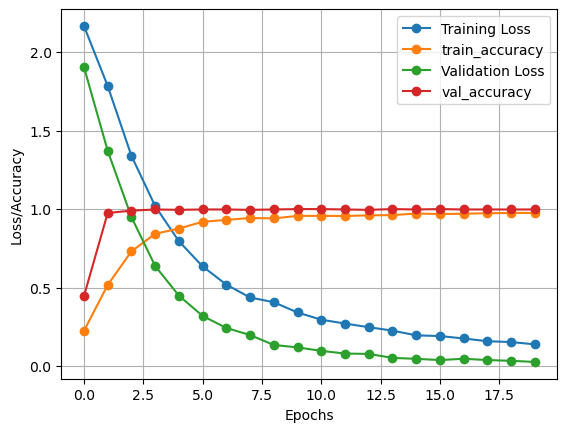

In [19]:
plt.plot(global_train_loss, marker = 'o')
plt.plot(train_accuracy, marker = 'o')

plt.plot(global_validation_loss, marker = 'o')
plt.plot(val_accuracy, marker = 'o')


plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.grid()

plt.legend(["Training Loss", "train_accuracy", "Validation Loss", "val_accuracy"])

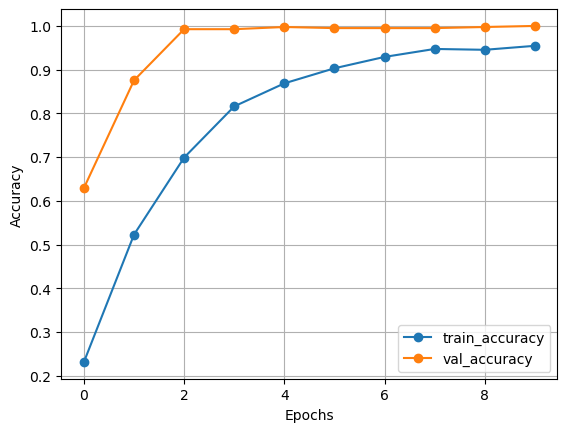

In [14]:
plt.plot(train_accuracy, marker = 'o')
plt.plot(val_accuracy, marker = 'o')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()

plt.legend(["train_accuracy", "val_accuracy"])

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

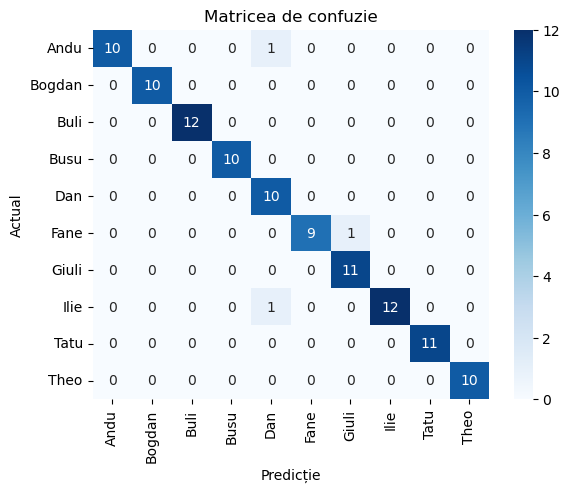

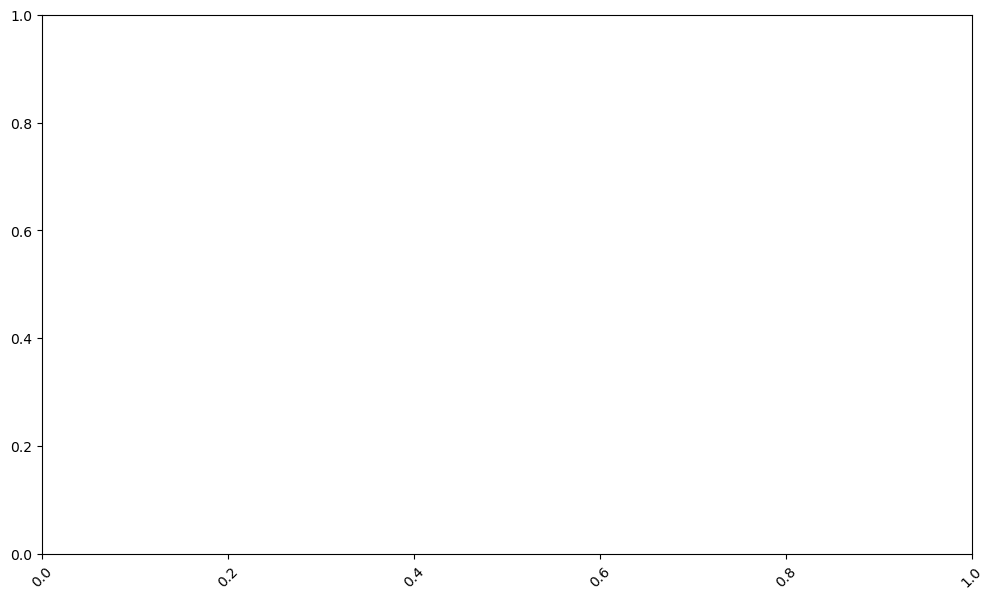

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for inputs, labels in people_dataloaders['test']:
    inputs = inputs.to(device) 
    labels = labels.to(device)
    
    output = model_people(inputs)
    
    output = F.softmax(output).cpu().data.numpy()
    
    y_pred.extend(output) #Save Predictions
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth
    

y_pred = np.argmax(y_pred, axis=1)

cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix, index=[i for i in people_classes], columns=[i for i in people_classes])

ax = plt.gca()
plt.figure(figsize=(12, 7))


sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax)

ax.set_xlabel('Predicție')
ax.set_ylabel('Actual')
ax.set_title('Matricea de confuzie')

plt.xticks(rotation=45)
plt.yticks(rotation=0)

#plt.savefig('output.png')